# MeanCount/MaxN calibration for MacNeil *et al* 2020

In [1]:
# Import packages
%matplotlib inline

import datetime
from itertools import product
import logging
import pickle
import pymc3 as pm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from math import isnan
from sklearn.preprocessing import LabelEncoder
from theano import tensor as tt
import matplotlib as mp
mp.rcParams['pdf.fonttype'] = 42
mp.rcParams['ps.fonttype'] = 42
import sklearn as sk

In [2]:
# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

In [3]:
# Set new plotting defaults
pct_formatter = StrMethodFormatter('{x:.1%}')

sns.set()
blue, green, *_ = sns.color_palette()

plt.rc('figure', figsize=(8, 6))

LABELSIZE = 15
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [4]:
# Import datasets
cdata = pd.read_csv('FIU1.csv')
ldata = pd.read_csv('FIU2.csv')
hdata = pd.read_csv('FIU3.csv')
zdata = pd.read_csv('FIU4.csv')
wdata = pd.read_csv('AIMS1.csv')
gdata = pd.read_csv('AIMS2.csv')
edata = pd.read_csv('Curtin.csv')

In [5]:
hdata.head()

,PI,MaxNReader,MeanCountReader,BruvID,FrameNumber,Location,MaxN,TimeToMaxN,MeanCountVideo
0,Heithaus,Alec,MarkB,FU1_001,1,Florida,0,0.0,0
1,Heithaus,Alec,MarkB,FU1_001,2,Florida,0,0.0,0
2,Heithaus,Alec,MarkB,FU1_001,3,Florida,0,0.0,0
3,Heithaus,Alec,MarkB,FU1_001,4,Florida,0,0.0,0
4,Heithaus,Alec,MarkB,FU1_001,5,Florida,0,0.0,0


Next use Pandas magic to create a single dataset

In [6]:
xdata = hdata.append(wdata).append(edata).append(cdata).append(gdata).append(zdata).append(ldata)
#xdata = zdata.append(ldata)
xdata.head()


/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,BruvID,FrameNumber,Location,MaxN,MaxN Reader,MaxNReader,MeanCount Reader,MeanCountReader,MeanCountVideo,PI,TimeToMaxN,Unnamed: 10,Unnamed: 11,Unnamed: 9
0,FU1_001,1,Florida,0,NaN,Alec,NaN,MarkB,0,Heithaus,0.0,NaN,NaN,NaN
1,FU1_001,2,Florida,0,NaN,Alec,NaN,MarkB,0,Heithaus,0.0,NaN,NaN,NaN
2,FU1_001,3,Florida,0,NaN,Alec,NaN,MarkB,0,Heithaus,0.0,NaN,NaN,NaN
3,FU1_001,4,Florida,0,NaN,Alec,NaN,MarkB,0,Heithaus,0.0,NaN,NaN,NaN
4,FU1_001,5,Florida,0,NaN,Alec,NaN,MarkB,0,Heithaus,0.0,NaN,NaN,NaN


To bulid a hierarchical model so we can compare BRUV-level estimates we'll need to index each BRUV and PI. 

In [7]:
# Index individual BRUVS
BRUV,Ib = indexall(xdata.BruvID.values)
nbruv = len(BRUV)

# Index BRUVS to PI
PI,Ip = subindexall(xdata.PI.values, xdata.BruvID.values)
npi = len(PI)

Make the response variables available

In [8]:
# Index MaxN to individual BRUVS
MaxN = np.zeros(nbruv)
MeanMeanCount = np.zeros(nbruv)
MeanTMaxN = np.zeros(nbruv)
MeanPI = []
for i in range(nbruv):
    MaxN[i] = xdata[xdata.BruvID==BRUV[i]].MaxN.max()
    MeanMeanCount[i] = xdata[xdata.BruvID==BRUV[i]].MeanCountVideo.mean()
    MeanTMaxN[i] = xdata[xdata.BruvID==BRUV[i]].TimeToMaxN.mean()

# Get MeanCounts
MeanCount = xdata.MeanCountVideo.values

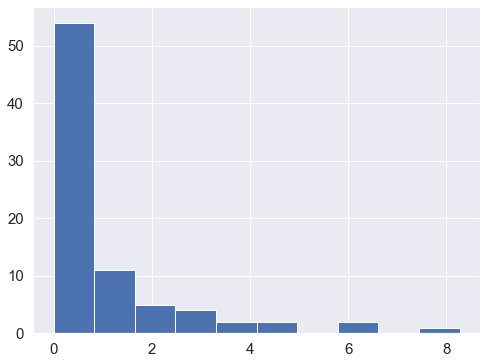

In [9]:
plt.hist(MeanMeanCount);

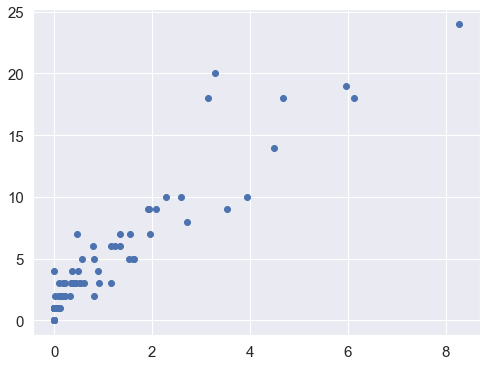

In [10]:
plt.scatter(MeanMeanCount, MaxN)

In [11]:
max(MaxN)

24.0

### Calibration model

In [12]:
Model = pm.Model()

with Model:
    # Exponential calibration parameters
    θ0 = pm.Normal('θ0', 0, 10)
    θ1 = pm.Normal('θ1', 0, 10)
    
    # Calibration curve
    μ = θ0+θ1*MeanMeanCount
    
    # Variance
    σ = pm.Uniform('σ', 1, 10)
    
    # Calibration likelihood
    Zi = pm.Normal('Zi', μ, σ, observed=MaxN)

In [13]:
# Sampling
with Model:
    # Draw samples
    trace = pm.sample(1000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, θ1, θ0]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3061.69draws/s]


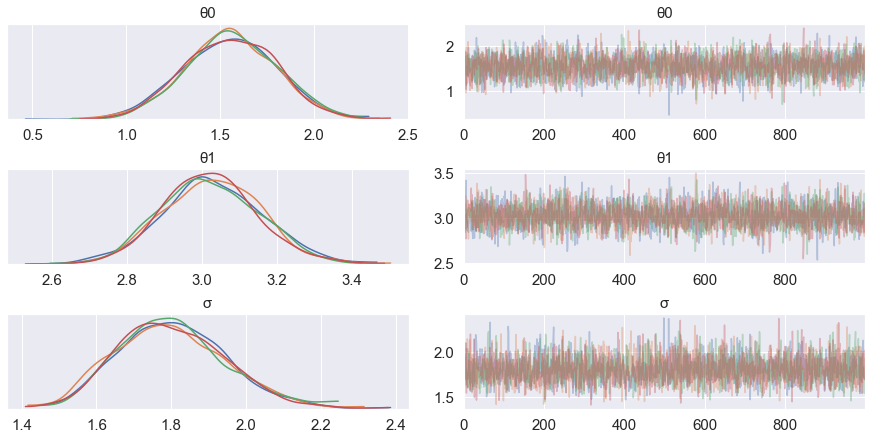

In [14]:
pm.traceplot(trace);

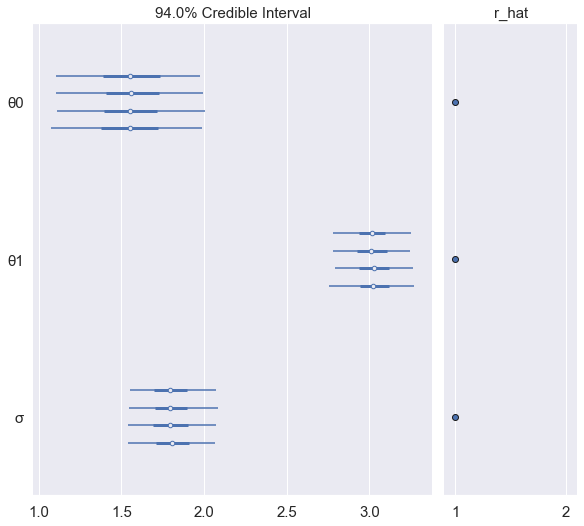

In [15]:
pm.forestplot(trace, r_hat=True);

In [16]:
results = pm.backends.tracetab.trace_to_dataframe(trace)
results.to_csv('maxn_calib.csv')

In [17]:
results.quantile([.05,.25,.5,.75,.95])

,θ0,θ1,σ
0.05,1.150858,2.822336,1.584374
0.25,1.389468,2.936636,1.701352
0.50,1.553635,3.020544,1.796106
0.75,1.724300,3.109271,1.899115
0.95,1.950609,3.238529,2.063622


In [18]:
pm.summary(trace)

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:992: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
θ0,1.554146,0.242011,0.004805,1.093354,2.018915,2906.488595,1.000160
θ1,3.024376,0.129792,0.002455,2.765513,3.270038,3038.666469,1.000245
σ,1.805126,0.147033,0.002491,1.540397,2.098846,3166.460575,1.000137


In [19]:
xnew = np.linspace(min(MeanMeanCount),max(MeanMeanCount),100)
ynew = (results['θ0'].median()+results['θ1'].median()*xnew)

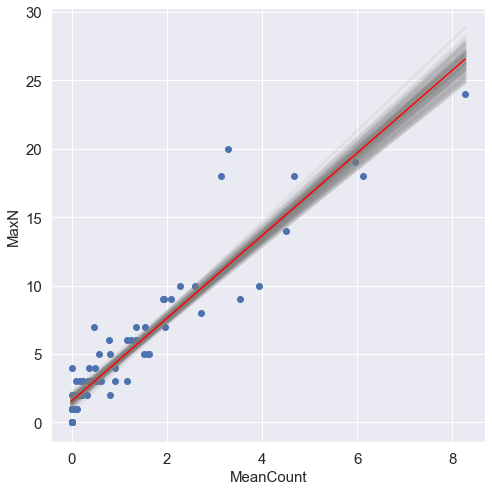

In [20]:
plt.figure(figsize=(7,7))

plt.scatter(MeanMeanCount, MaxN)
[plt.plot(xnew,(results['θ0'][i]+results['θ1'][i]*xnew), alpha=0.1, color='grey', linewidth=3) for i in np.random.choice(range(len(results['θ1'])),100,replace=False)]
plt.plot(xnew,ynew,c='red')

plt.xlabel('MeanCount')
plt.ylabel('MaxN')

plt.tight_layout()
plt.savefig('MeanCount_MaxN.pdf');

# Bootstrapping 

In response to a Referee's comments about the unreliablity of the relationship above, we also conducted a bootstrapping proceedure for 1000 linear model estimates of 5 samples of the data (without replacement). 

In [21]:
import statsmodels.api as sm

In [22]:
# Number of resamples
nsamp = 1000

# Empty list to hold estimates
boot_slope = np.zeros(nsamp)
boot_slope_ci = np.zeros(nsamp)
boot_inter = np.zeros(nsamp)

# Length of data
nobs = len(MaxN)

In [23]:
for i in range(nsamp):
    # Random sets of data
    samp = np.random.choice(nobs, 5, replace=True)
    x = sm.add_constant(MeanMeanCount[samp].reshape(-1,1))
    y = MaxN[samp].reshape(-1,1)
    tmp = sm.OLS(y, x).fit()
    boot_slope[i] = tmp.params[1]
    boot_inter[i] = tmp.params[0]
    boot_slope_ci[i]= (tmp.conf_int()[1][0]>0)*1    

In [24]:
sum(boot_slope_ci>0)/len(boot_slope_ci)

0.822

In [25]:
np.percentile(boot_inter,(50,5,95))

array([1.26321223, 0.3552243 , 2.66899798])

In [26]:
np.percentile(boot_slope,(50,5,95))

array([3.20033297, 1.89118549, 6.1973961 ])

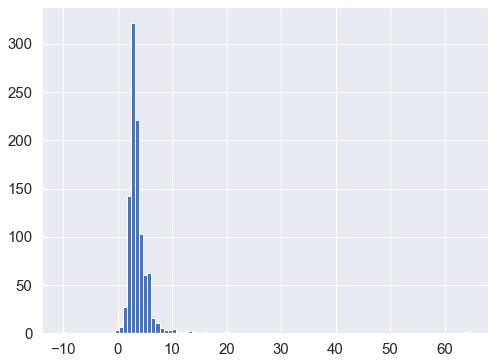

In [27]:
plt.hist(boot_slope, bins=100);

In [28]:
xnew = np.linspace(min(MeanMeanCount),max(MeanMeanCount),100)
ynew = np.median(boot_inter)+np.median(boot_slope)*xnew

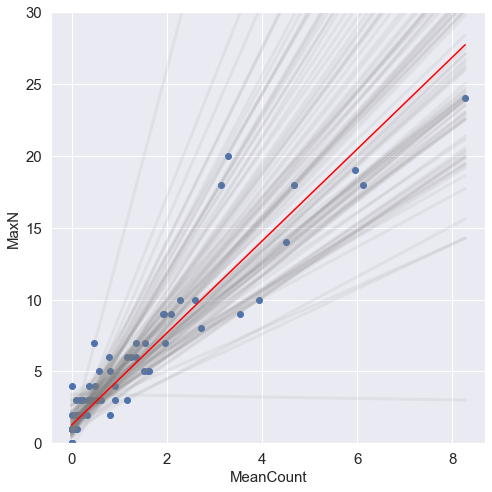

In [29]:
plt.figure(figsize=(7,7))

plt.scatter(MeanMeanCount, MaxN)
[plt.plot(xnew,(boot_inter[i]+boot_slope[i]*xnew), alpha=0.1, color='grey', linewidth=3) for i in np.random.choice(range(len(boot_slope)),100,replace=False)]
plt.plot(xnew,ynew,c='red')

plt.xlabel('MeanCount')
plt.ylabel('MaxN')

plt.ylim(0,30)

plt.tight_layout()
plt.savefig('MeanCount_MaxN_boot.pdf');

## Power analysis

In [30]:
nsampls = np.linspace(3,11,9).astype(int)
px = np.zeros(len(nsampls))

for j in nsampls:
    # Number of resamples
    nsamp = 1000

    # Empty list to hold estimates
    boot_slope = np.zeros(nsamp)
    boot_inter = np.zeros(nsamp)
    boot_slope_ci = np.zeros(nsamp)

    # Length of data
    nobs = len(MaxN)

    for i in range(nsamp):
        # Random sets of data
        samp = np.random.choice(nobs, j, replace=True)
        x = sm.add_constant(MeanMeanCount[samp].reshape(-1,1))
        y = MaxN[samp].reshape(-1,1)
        tmp = sm.OLS(y, x).fit()
        boot_slope[i] = tmp.params[1]
        boot_inter[i] = tmp.params[0]
        boot_slope_ci[i]= (tmp.conf_int()[1][0]>0)*1
        
    px[j-3] = sum(boot_slope_ci>0)/len(boot_slope_ci)


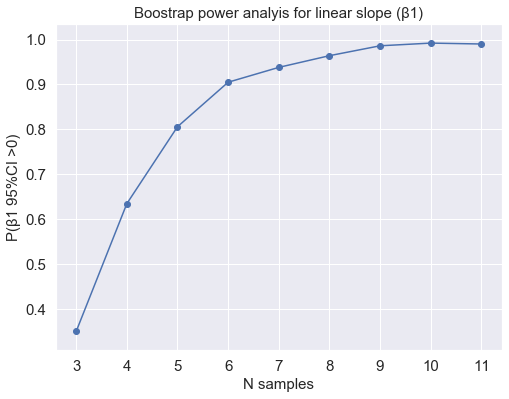

In [31]:
plt.scatter(nsampls,px)
plt.plot(nsampls,px)
plt.title('Boostrap power analyis for linear slope (β1)')
plt.xlabel('N samples')
plt.ylabel('P(β1 95%CI >0)')
plt.savefig('MeanCount_MaxN_power.pdf');